# Using DoWhy for Causal Inference
This notebook aims to demonstrate the capabilites of using the Causal Framework to make causal inference from observational data, and the tools we have available to validate our conclusions, all of them powered by Microsoft's DoWHy package.

First, let us add the required path for Python to find the DoWhy code and load all required packages.

## Loading Packages and Dependencies

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

Let's check the python version. 

In [31]:
import numpy as np
import pandas as pd
import logging # implement a flexible event logging system for applications and libraries.
import seaborn as sns
import matplotlib as plt
# dowhy framework
import dowhy
import dowhy.api
from dowhy import CausalModel
import dowhy.datasets
from dowhy.do_samplers.weighting_sampler import WeightingSampler

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome. 

Beta is the true causal effect. 

In [3]:
data = dowhy.datasets.linear_dataset(
    beta=10, # causal coef
    num_common_causes=7, # cofounders
    num_instruments = 2, #vi
    num_treatments=1, # treatment
    num_samples=10000, # sample
    treatment_is_binary=True,
    outcome_is_binary=False
)
df = data["df"]
df.head()

,Z0,Z1,W0,W1,W2,W3,W4,W5,W6,v0,y
0,1.0,0.952178,0.185966,0.766709,-0.578463,0.849988,1.344869,-0.934260,-0.573142,True,8.399905
1,1.0,0.838307,0.567880,1.537024,1.911924,-1.169329,1.674871,-1.120045,-1.121839,True,12.013163
2,0.0,0.032509,0.548545,0.222517,2.348690,0.110176,-1.242219,-0.465876,0.366009,True,21.243639
3,1.0,0.696951,0.615317,-0.182365,1.597197,-0.418816,-0.875438,-2.255156,-1.460824,True,2.161478
4,1.0,0.267943,-1.701793,0.156612,1.458845,0.560431,0.924666,-0.400429,-0.455174,True,15.772064


Note that we are using a pandas dataframe to load the data. At present, DoWhy only supports pandas dataframe as input.

## Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Z0      10000 non-null  float64
 1   Z1      10000 non-null  float64
 2   W0      10000 non-null  float64
 3   W1      10000 non-null  float64
 4   W2      10000 non-null  float64
 5   W3      10000 non-null  float64
 6   W4      10000 non-null  float64
 7   W5      10000 non-null  float64
 8   W6      10000 non-null  float64
 9   v0      10000 non-null  bool   
 10  y       10000 non-null  float64
dtypes: bool(1), float64(10)
memory usage: 791.1 KB


In [5]:
# Unbeliavable to check how corr changes nothing with the treatment having or not causal impact 
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Z0,Z1,W0,W1,W2,W3,W4,W5,W6,v0,y
Z0,1.000000,0.001963,0.005566,0.004092,-0.005608,-0.004830,0.013033,0.010754,0.002121,0.204665,0.034766
Z1,0.001963,1.000000,0.010267,0.014344,-0.009284,0.002847,0.003241,0.004931,0.021202,0.110530,0.028865
W0,0.005566,0.010267,1.000000,-0.001069,0.006966,-0.001526,0.002928,0.010244,0.000677,0.188431,0.158292
W1,0.004092,0.014344,-0.001069,1.000000,0.007340,0.012492,0.002742,0.007177,-0.006502,0.084478,0.233969
W2,-0.005608,-0.009284,0.006966,0.007340,1.000000,0.014862,0.002906,0.000104,-0.005020,0.101685,0.577244
W3,-0.004830,0.002847,-0.001526,0.012492,0.014862,1.000000,-0.003171,-0.001082,-0.001117,0.067795,0.476458
W4,0.013033,0.003241,0.002928,0.002742,0.002906,-0.003171,1.000000,0.004509,-0.018433,0.019877,0.129831
W5,0.010754,0.004931,0.010244,0.007177,0.000104,-0.001082,0.004509,1.000000,-0.007267,0.053948,0.394587
W6,0.002121,0.021202,0.000677,-0.006502,-0.005020,-0.001117,-0.018433,-0.007267,1.000000,0.023447,0.415778
v0,0.204665,0.110530,0.188431,0.084478,0.101685,0.067795,0.019877,0.053948,0.023447,1.000000,0.316579


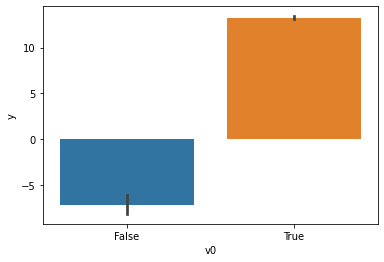

In [6]:
sns.barplot(data=df, x='v0', y='y')

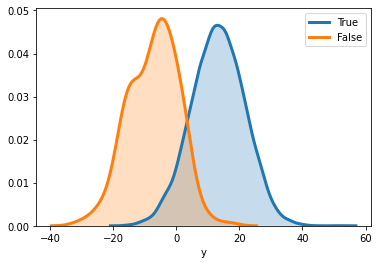

In [34]:
# 
interventions = df.v0.unique()

# Iterate through the five airlines
for intervention in interventions:
    # Subset to the airline
    subset = df[df['v0'] == intervention]
    
    # Draw the density plot
    sns.distplot(subset['y'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = intervention)
    
# Plot formatting
#plt.legend(prop={'size': 16}, title = 'Airline')
#plt.title('Density Plot with Multiple Airlines')
#plt.xlabel('Delay (min)')
#plt.ylabel('Density')

In [7]:
#cofounders_y = [col for col in df.columns if 'W' in col or 'y'in col]
#sns.pairplot(df[cofounders_y])

## Causal Framework

### **Model** Phase - input the "graph"

We now input a causal graph in the GML graph format (recommended). You can also use the DOT format.

In [8]:
# With graph
model=CausalModel(
    data = df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"], # both works the same, but the first is based on a previous graph
    instruments=data["instrument_names"],
    logging_level = logging.INFO # not 100% of its funcionality, but I suppose it serves to gain efficiency
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


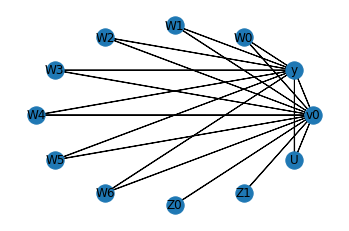

In [9]:
model.view_model()

In [10]:
#from IPython.display import Image, display
#display(Image(filename="causal_model.png"))

The above causal graph shows the assumptions encoded in the causal model. We can now use this graph to first identify 
the causal effect (go from a causal estimand to a probability expression), and then estimate the causal effect.

**DoWhy philosophy: Keep identification and estimation separate**

Identification can be achieved without access to the data, acccesing only the graph. This results in an expression to be computed. This expression can then be evaluated using the available data in the estimation step.
It is important to understand that these are orthogonal steps.

### Identification Phase

In [11]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W4', 'U', 'W5', 'W1', 'W2', 'W3', 'W6', 'W0']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W5,W1,W2,W3,W6,W0,U) = P(y|v0,W4,W5,W1,W2,W3,W6,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)



### Estimation Phase

Fundamentally, test at least two different methods to have more confidence on the effect. Here, we'll examine ass built-in methods inside DoWhy

* Linear Regression

Brief Explanation of T's and B's 

In [12]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W5,W1,W2,W3,W6,W0,U) = P(y|v0,W4,W5,W1,W2,W3,W6,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W4+W5+W1+W2+W3+W6+W0
## Estimate
Value: 9.999999999999964



* Propensity-based Stratification

Brief Explanation of T's and B's 

In [13]:
causal_estimate = model.estimate_effect(
    identified_estimand,method_name="backdoor.propensity_score_stratification"
)
print(causal_estimate)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W5,W1,W2,W3,W6,W0,U) = P(y|v0,W4,W5,W1,W2,W3,W6,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W4+W5+W1+W2+W3+W6+W0
## Estimate
Value: 10.252676484347129



* Propensity Score Matching

Brief Explanation of T's and B's 

In [14]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W5,W1,W2,W3,W6,W0,U) = P(y|v0,W4,W5,W1,W2,W3,W6,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W4+W5+W1+W2+W3+W6+W0
## Estimate
Value: 16.04709499950085



* Inverse Propensity Weighting

Brief Explanation of T's and B's 

We will be using (inverse) propensity scores to assign weights to units in the data. DoWhy supports a few different weighting schemes:
1. Vanilla Inverse Propensity Score weighting (IPS) (weighting_scheme="ips_weight")
2. Self-normalized IPS weighting (also known as the Hajek estimator) (weighting_scheme="ips_normalized_weight")
3. Stabilized IPS weighting (weighting_scheme = "ips_stabilized_weight")

In [15]:
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    target_units = "ate",
    method_params={"weighting_scheme":"ips_normalized_weight"}
)
print(causal_estimate)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W5,W1,W2,W3,W6,W0,U) = P(y|v0,W4,W5,W1,W2,W3,W6,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W4+W5+W1+W2+W3+W6+W0
## Estimate
Value: 17.892396495118295



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


* Binary Instrument/Wald Estimator

Brief Explanation of T's and B's 

In [16]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", method_params = {'iv_instrument_name': ['Z0']})
print(causal_estimate)

INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y is affected in the same way by common causes of ['v0'] and y



*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W5,W1,W2,W3,W6,W0,U) = P(y|v0,W4,W5,W1,W2,W3,W6,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2,

* Regression Discontinuity

(Worth to mention this design wouldn't be suited to this case) 
Brief Explanation of T's and B's 

In [17]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="iv.regression_discontinuity", 
        method_params={'rd_variable_name':'Z1',
                       'rd_threshold_value':0.5,
                       'rd_bandwidth': 0.1})
print(causal_estimate)

INFO:dowhy.causal_estimator:Using Regression Discontinuity Estimator
INFO:dowhy.causal_estimator:
INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(y, local_rd_variable))⋅Expectation(Derivative(v0, local

              -1
_rd_variable))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['local_treatment'] is affected in the same way by common causes of ['local_treatment'] and local_outcome
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome local_outcome is affected in the same way by common causes of ['local_treatment'] and local_outcome



      local_rd_variable  local_treatment  local_outcome
17             0.587663             True      16.735838
32             0.558842             True       4.235377
42             0.528779             True      22.030615
43             0.582572             True      16.139430
45             0.586549             True       2.934968
...                 ...              ...            ...
9969           0.437027             True       2.489741
9978           0.513033             True      14.086854
9980           0.489366             True      29.300886
9990           0.486356             True       7.368931
9995           0.591452             True      18.760037

[1988 rows x 3 columns]
*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfounded

* Heterogeneous Treatment Estimation Support

You can input additional parameters to the estimate_effect method. For instance, to estimate the effect on any subset of the units, you can specify the "target_units" parameter which can be a string ("ate", "att", or "atc"), lambda function that filters rows of the data frame, or a new dataframe on which to compute the effect. You can also specify "effect modifiers" to estimate heterogeneous effects across these variables. See `help(CausalModel.estimate_effect)`. 

In [18]:
# Causal effect on the control group (ATC)
causal_estimate_atc = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_atc)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W5,W1,W2,W3,W6,W0,U) = P(y|v0,W4,W5,W1,W2,W3,W6,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W4+W5+W1+W2+W3+W6+W0
## Estimate
Value: 10.354852941146467



## Refuting Phase

We get the same causal graph. Now identification and estimation is done as before.

In [19]:
estimate_to_refute = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")         
print("Causal Estimate is " + str(estimate_to_refute.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0


Causal Estimate is 10.252676484347129


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Adding a random common cause variable

Add theoretical hypothesis behind this refuting technic

In [20]:
res_random=model.refute_estimate(
    identified_estimand, estimate_to_refute
    , method_name="random_common_cause", random_seed = 667
)
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0+w_random


Refute: Add a Random Common Cause
Estimated effect:(10.252676484347129,)
New effect:(10.280796680941915,)



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Adding an unobserved common cause variable

Add theoretical hypothesis behind this refuting technic

In [21]:
res_unobserved=model.refute_estimate(
    identified_estimand, estimate_to_refute, method_name="add_unobserved_common_cause"
    , confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear"
    , effect_strength_on_treatment=0.05, effect_strength_on_outcome=0.02, random_seed = 667
)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Add an Unobserved Common Cause
Estimated effect:(10.252676484347129,)
New effect:(1.87369379643151,)



### Replacing treatment with a random (placebo) variable

Add theoretical hypothesis behind this refuting technic

In [22]:
res_placebo=model.refute_estimate(
    identified_estimand, estimate_to_refute, random_seed = 667
    , method_name="placebo_treatment_refuter", placebo_type="permute"
)
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W4+W5+W1+W2+W3+W6+W0


Refute: Use a Placebo Treatment
Estimated effect:(10.252676484347129,)
New effect:(nan,)



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:96: RuntimeWarning: invalid value encountered in double_scalars
  est = (weighted_outcomes['effect'] * (weighted_outcomes[control_sum_name]+weighted_outcomes[treatment_sum_name])).sum() / total_population


### Removing a random subset of the data

Add theoretical hypothesis behind this refuting technic

In [23]:
res_subset=model.refute_estimate(
    identified_estimand, estimate_to_refute, random_seed = 667
    , method_name="data_subset_refuter", subset_fraction=0.9
)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Use a subset of data
Estimated effect:(10.252676484347129,)
New effect:(10.520028319997916,)



## Other Package Interesting Funcionalities

### Do Sampler

Add brief theoretical explanation of what it is, Ts and Bs

In [36]:
do_df=(
    df
    .causal.do(
        x='v0',outcome='y',common_causes=[ 'W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']
        ,variable_types={
            'v0':'b','y':'c','W0':'c', 'W1':'c', 'W2':'c'
            , 'W3':'c', 'W4':'c', 'W5':'c', 'W6':'c'
        }
    )
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W4', 'U', 'W5', 'W1', 'W2', 'W3', 'W6', 'W0']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume iid data.


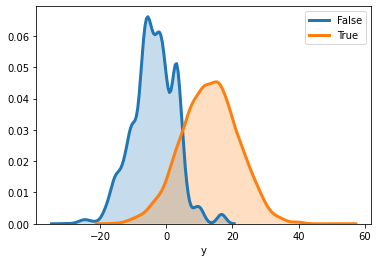

In [37]:
# 
interventions = do_df.v0.unique()

# Iterate through the five airlines
for intervention in interventions:
    # Subset to the airline
    subset = do_df[do_df['v0'] == intervention]
    
    # Draw the density plot
    sns.distplot(subset['y'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = intervention)